# Отчет по линейной регрессии

**Выполнил:** Кляйншмидт М., группа АП-226  

---

## 1. Введение

**Цель работы:**  

Изучить основы и построить простейшие модели линейной регрессии. Обучить модель на реальных данных и оценить её качество.

In [47]:
import pandas as pd
import os

# Загрузка датасета
# Предполагается, что файл Concrete_Data.csv находится в той же директории, что и ноутбук.
data_path = os.path.join(os.getcwd(), "Concrete_Data.csv")

# Чтение данных
df = pd.read_csv(data_path)

# Общая информация
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())


Размер датасета: (1030, 9)

Первые 5 строк:
   cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   coarse_aggregate  fine_aggregate   age  concrete_compressive_strength  
0            1040.0            676.0   28                          79.99  
1            1055.0            676.0   28                          61.89  
2             932.0            594.0  270                          40.27  
3             932.0            594.0  365                          41.05  
4             978.4            825.5  360                          44.30  


## Вывод по разделу 1

Постановка задачи корректна: выбранный числовой датасет **Concrete Compressive Strength** с платформы Kaggle полностью соответствует цели работы.  
Он содержит все необходимые параметры состава бетонной смеси и целевую переменную — **прочность бетона на сжатие (МПа)**.  
Такой набор данных позволяет построить и проанализировать простейшие модели линейной и гребневой регрессии, а также оценить их качество с помощью метрик **RMSE**, **R²** и **MAPE**.


## 2. Анализ данных

Рассмотрим структуру датасета, визуализируем распределения признаков и построим корреляционную матрицу, чтобы выявить взаимосвязи между параметрами состава бетона и его прочностью.


Топ-10 признаков по модулю skew (асимметрия):


,skew,kurt
age,3.269177,12.168989
superplasticizer,0.907203,1.411269
blast_furnace_slag,0.800717,-0.508175
fly_ash,0.537354,-1.328746
cement,0.509481,-0.520652
fine_aggregate,-0.253010,-0.102177
water,0.074628,0.122082
coarse_aggregate,-0.040220,-0.599016


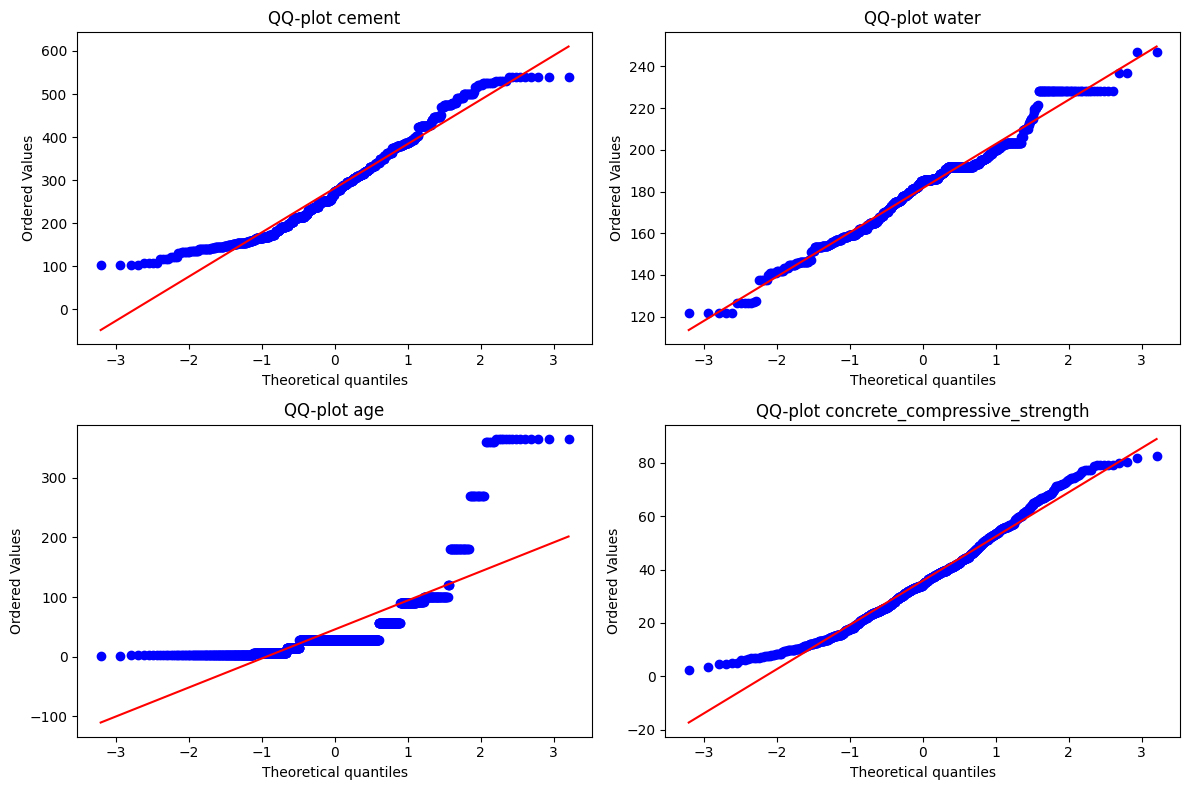

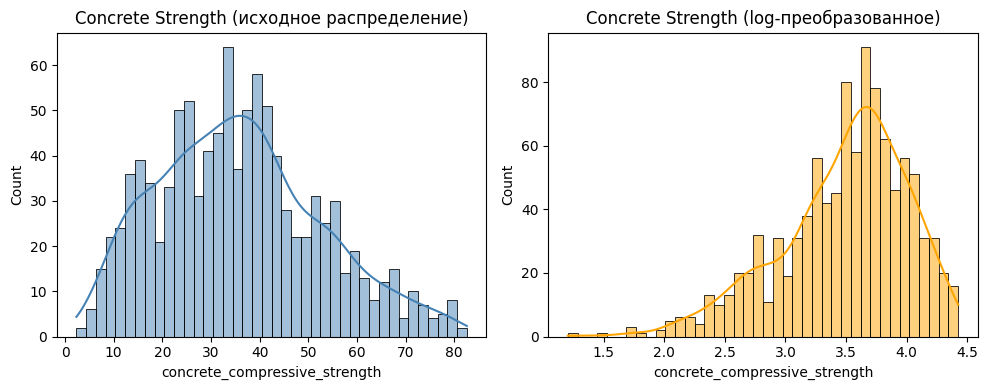

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Убираем возможные пробелы в именах колонок
df.columns = [c.strip() for c in df.columns]

# Список числовых признаков
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'concrete_compressive_strength']

# Расчёт асимметрии и эксцесса
desc = df[num_cols].agg(['skew', 'kurt']).T.sort_values(by='skew', key=lambda s: s.abs(), ascending=False)
print("Топ-10 признаков по модулю skew (асимметрия):")
display(desc.head(10))

# Пары признаков для визуальной проверки
important_cols = ['cement', 'water', 'age', 'concrete_compressive_strength']

plt.figure(figsize=(12, 8))
for i, col in enumerate(important_cols, start=1):
    plt.subplot(2, 2, i)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f'QQ-plot {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['concrete_compressive_strength'], bins=40, kde=True, color='steelblue')
plt.title('Concrete Strength (исходное распределение)')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['concrete_compressive_strength']), bins=40, kde=True, color='orange')
plt.title('Concrete Strength (log-преобразованное)')
plt.tight_layout()
plt.show()


## Анализ QQ-плотов и гистограмм

**QQ-plot: cement**  
Отклонение от нормальности: точки в хвостах слегка отклоняются вверх, наблюдается небольшой правый перекос.  
Средняя часть распределения достаточно близка к диагонали, что указывает на умеренное соответствие нормальному типу.  
**Вывод:** распределение признака *cement* близко к нормальному, возможны незначительные выбросы в верхнем диапазоне.

---

**QQ-plot: water**  
Отклонение от нормальности: в правом хвосте точки поднимаются выше линии, указывая на присутствие наблюдений с повышенным содержанием воды.  
Левая часть распределения слегка сплющена, что отражает лёгкую асимметрию.  
**Вывод:** распределение *water* правоскошенное; значения с высоким содержанием воды встречаются редко, но влияют на форму хвоста.

---

**QQ-plot: age**  
Отклонение от нормальности: график имеет выраженную S-образную форму; нижние значения сильно сжаты, а верхние формируют длинный правый хвост.  
Это свидетельствует о высокой концентрации малых возрастов и наличии экстремальных значений (старые образцы).  
**Вывод:** распределение *age* существенно отклоняется от нормального, требуется масштабирование или логарифмирование для стабилизации разброса.

---

**QQ-plot: concrete_compressive_strength**  
Отклонение от нормальности: точки в целом следуют диагонали, но наблюдается небольшой подъем в правом хвосте.  
Это указывает на лёгкую правостороннюю асимметрию — присутствуют смеси с высокой прочностью, формирующие вытянутый хвост.  
**Вывод:** распределение *concrete_compressive_strength* близко к нормальному, но с небольшим перекосом вправо.

---

### Гистограммы: concrete_compressive_strength (исходное) vs log1p(concrete_compressive_strength)
- **Исходное распределение:** заметен правый перекос и удлинённый хвост; значения с высокой прочностью встречаются реже, но существенно влияют на общую форму.  
- **После логарифмирования:** распределение становится более симметричным и напоминает нормальное «колоколообразное»; хвосты сглажены, дисперсия стабилизирована.  

**Вывод:** лог-преобразование (`log1p`) целевой переменной улучшает нормальность распределения и делает данные более подходящими для линейных моделей.

---

### Практические следствия
- Для повышения устойчивости модели к выбросам и асимметрии рекомендуется использовать логарифмированное значение целевой переменной.  
- Признак *age* можно нормализовать или преобразовать (например, `log1p(age)`), чтобы уменьшить влияние длинного хвоста.  
- В целом данные пригодны для обучения линейной и гребневой регрессии; незначительные отклонения от нормальности не требуют жёсткой коррекции, но лог-трансформация улучшает стабильность модели.


Числовых признаков: 9


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
cement,1.00,-0.28,-0.40,-0.08,0.09,-0.11,-0.22,0.08,0.50
blast_furnace_slag,-0.28,1.00,-0.32,0.11,0.04,-0.28,-0.28,-0.04,0.13
fly_ash,-0.40,-0.32,1.00,-0.26,0.38,-0.01,0.08,-0.15,-0.11
water,-0.08,0.11,-0.26,1.00,-0.66,-0.18,-0.45,0.28,-0.29
superplasticizer,0.09,0.04,0.38,-0.66,1.00,-0.27,0.22,-0.19,0.37
coarse_aggregate,-0.11,-0.28,-0.01,-0.18,-0.27,1.00,-0.18,-0.00,-0.16
fine_aggregate,-0.22,-0.28,0.08,-0.45,0.22,-0.18,1.00,-0.16,-0.17
age,0.08,-0.04,-0.15,0.28,-0.19,-0.00,-0.16,1.00,0.33
concrete_compressive_strength,0.50,0.13,-0.11,-0.29,0.37,-0.16,-0.17,0.33,1.00


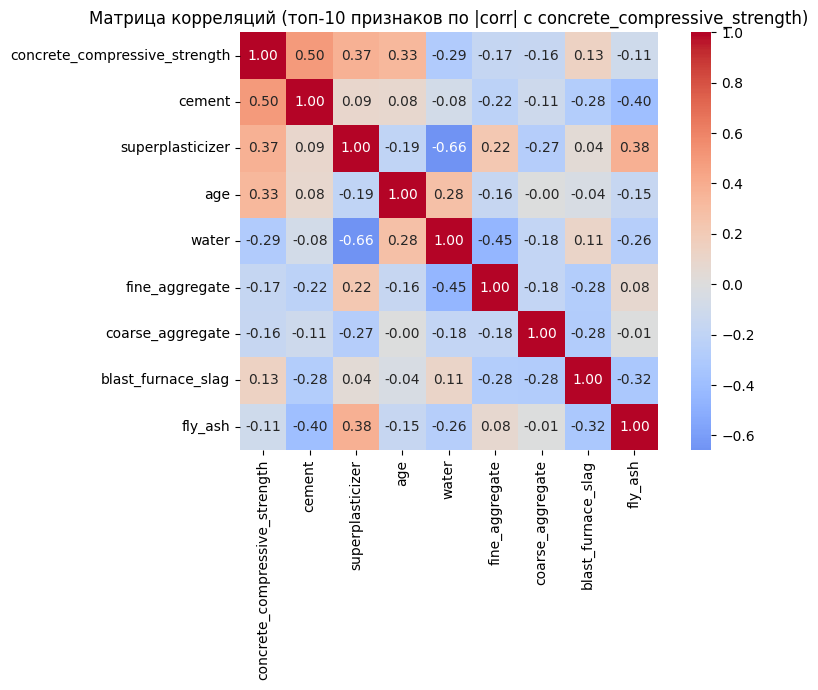

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Только числовые признаки
numeric_df = df.select_dtypes(include=['int64', 'float64']).copy()

# Полная корреляционная матрица
corr_full = numeric_df.corr(numeric_only=True)

print(f"Числовых признаков: {numeric_df.shape[1]}")
display(corr_full.round(2))

# Топ-10 признаков по корреляции с целевой переменной
target = 'concrete_compressive_strength'
top_cols = corr_full[target].abs().sort_values(ascending=False).head(10).index.tolist()

corr_top = corr_full.loc[top_cols, top_cols]

plt.figure(figsize=(9, 7))
sns.heatmap(corr_top, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Матрица корреляций (топ-10 признаков по |corr| с concrete_compressive_strength)")
plt.tight_layout()
plt.show()


## Выводы по матрице корреляций (топ-10 числовых признаков)

**Связь с прочностью бетона (concrete_compressive_strength) — сильные положительные:**
- **cement** — самая высокая корреляция (r ≈ 0.50): увеличение содержания цемента напрямую повышает прочность смеси.  
- **superplasticizer** — умеренно высокая положительная связь (r ≈ 0.37): пластификаторы способствуют равномерному распределению частиц и увеличению прочности.  
- **age** — положительная корреляция (r ≈ 0.33): со временем бетон набирает прочность за счёт протекания гидратации.

**Связь с прочностью — умеренные отрицательные:**
- **water** — заметная отрицательная корреляция (r ≈ –0.29): избыток воды снижает плотность и прочность бетона.  
- **fine_aggregate** и **coarse_aggregate** — слабая отрицательная связь (r ≈ –0.16…–0.17): возможен небольшой разброс из-за неоднородности заполнителя.  
- **fly_ash** — слабая отрицательная зависимость (r ≈ –0.11).  

**Мультиколлинеарность между признаками:**
- **superplasticizer ↔ water** — высокая отрицательная взаимная корреляция (r ≈ –0.66): при увеличении дозы пластификатора требуется меньше воды.  
- **cement ↔ fly_ash** — умеренная отрицательная зависимость (r ≈ –0.40): материалы частично взаимозаменяемы в составе смеси.  
- **blast_furnace_slag ↔ fly_ash** — слабая отрицательная корреляция (r ≈ –0.32).

**Импликации для модели:**
- Возможна **мультиколлинеарность** между отдельными признаками (например, *water* и *superplasticizer*),  
  что может вызвать нестабильность коэффициентов в обычной линейной регрессии.  
- Для снижения влияния коррелирующих факторов целесообразно применить **регуляризацию (Ridge)**  
  или провести анализ VIF для уточнения набора предикторов.  
- Основные зависимости с прочностью бетона логичны с точки зрения физико-химических процессов:  
  цемент и возраст повышают прочность, а избыток воды её снижает.

**Интерпретация ключевых признаков:**
- *cement* — содержание цемента, главный фактор прочности.  
- *superplasticizer* — добавка, улучшающая структуру и работу смеси.  
- *age* — возраст бетона (в днях), напрямую влияет на набор прочности.  
- *water* — количество воды, влияет обратнопропорционально.  
- *fly_ash*, *blast_furnace_slag* — минеральные добавки, частично заменяющие цемент.  
- *coarse_aggregate*, *fine_aggregate* — заполнитель (гравий, песок), формируют структуру, но слабее влияют на итоговую прочность.



Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None

Статистическое описание данных:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
mean,281.17,73.90,54.19,181.57,6.20,972.92,773.58,45.66,35.82
std,104.51,86.28,64.00,21.35,5.97,77.75,80.18,63.17,16.71
min,102.00,0.00,0.00,121.80,0.00,801.00,594.00,1.00,2.33
25%,192.38,0.00,0.00,164.90,0.00,932.00,730.95,7.00,23.71
50%,272.90,22.00,0.00,185.00,6.40,968.00,779.50,28.00,34.44
75%,350.00,142.95,118.30,192.00,10.20,1029.40,824.00,56.00,46.14
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


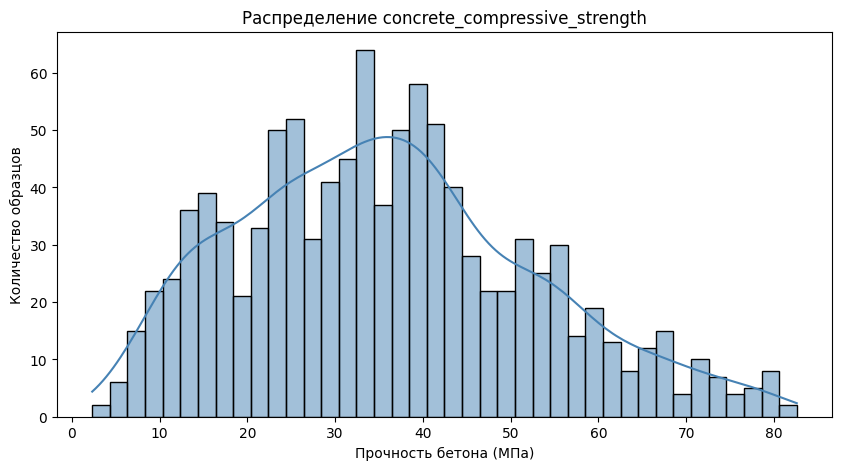

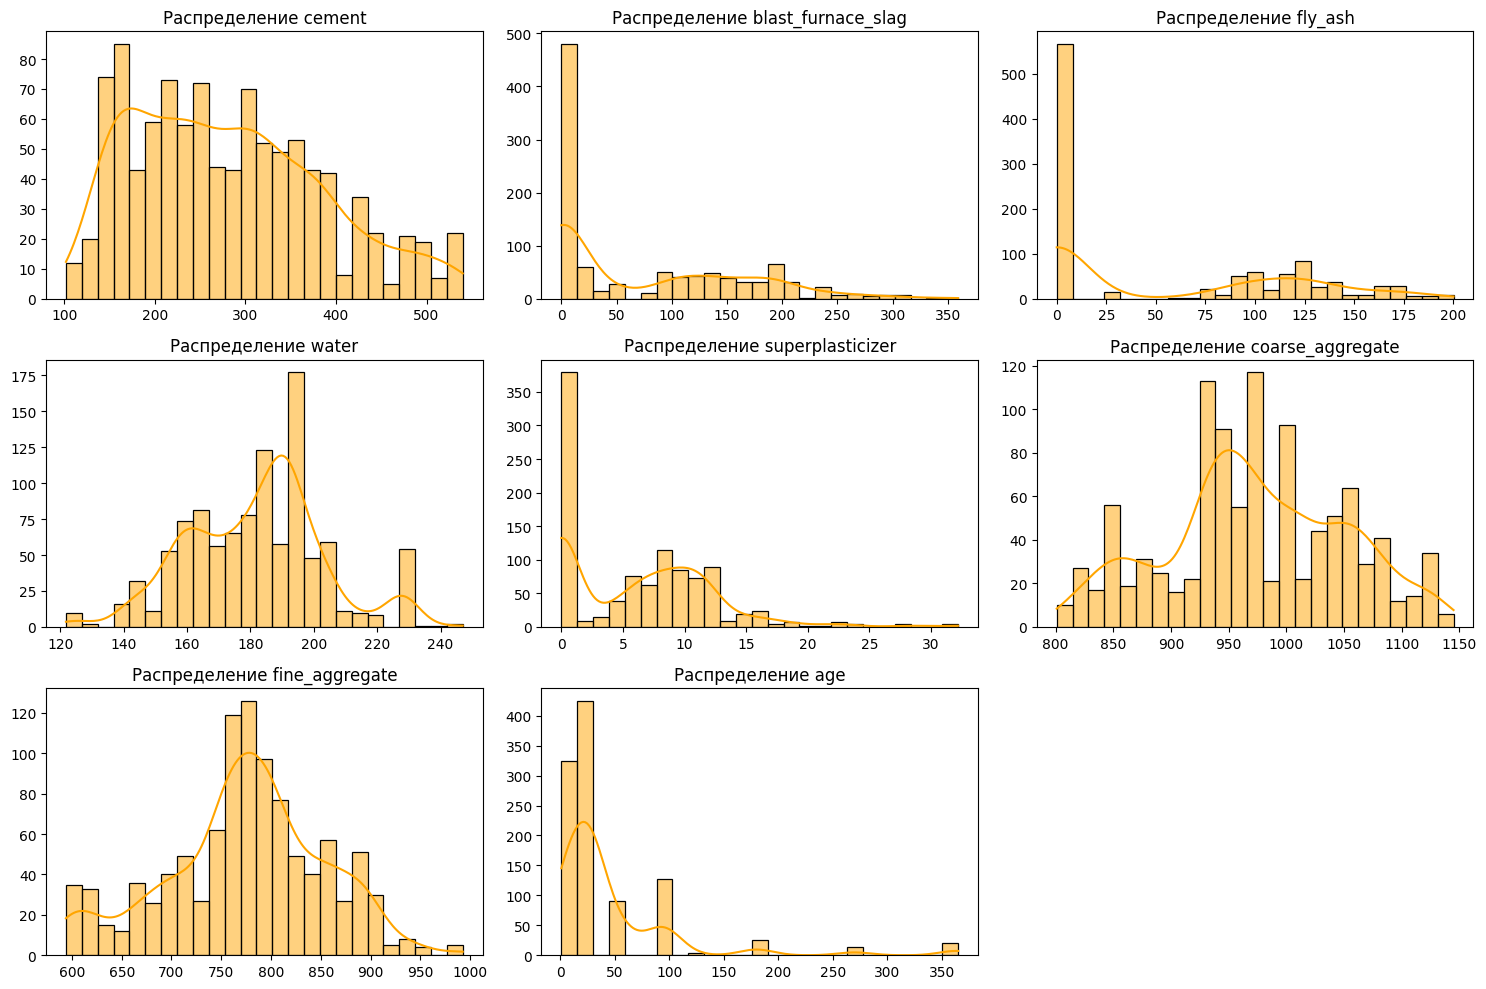

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Общая информация о данных
print("\nОбщая информация о датасете:")
print(df.info())

print("\nСтатистическое описание данных:")
display(df.describe().round(2))

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='concrete_compressive_strength', kde=True, bins=40, color='steelblue')
plt.title('Распределение concrete_compressive_strength')
plt.xlabel('Прочность бетона (МПа)')
plt.ylabel('Количество образцов')
plt.show()

# Визуализация распределений по остальным числовым признакам
numeric_cols = [c for c in df.columns if c != 'concrete_compressive_strength']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=25, color='orange')
    plt.title(f'Распределение {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()


## Наблюдения по графикам распределений

**Целевая переменная — concrete_compressive_strength**  
Форма: одновершинная, плавно убывающая к правому краю; визуально напоминает нормальное распределение с небольшой правосторонней асимметрией.  
Нормальность: QQ-плот показывает лёгкое отклонение точек в правом хвосте — наличие образцов с повышенной прочностью, но общая форма приемлема для линейного моделирования.  
Логарифмирование (`log1p`) делает распределение более симметричным и приближает его к нормальному виду.

---

**Числовые признаки**  
- **cement:** распределение близко к нормальному, основное ядро сосредоточено в диапазоне 200–500 кг/м³; крайние значения наблюдаются редко.  
- **blast_furnace_slag:** умеренно правоскошенное, большинство наблюдений сосредоточено в нижнем диапазоне.  
- **fly_ash:** правосторонняя асимметрия; в выборке присутствуют смеси без золы, что создаёт скопление значений у нуля.  
- **water:** слабо правоскошенное распределение; основное ядро выборки компактное.  
- **superplasticizer:** ярко выраженная правосторонняя асимметрия — большинство значений малы, но есть редкие большие дозировки.  
- **coarse_aggregate:** почти симметричное распределение, близкое к нормальному.  
- **fine_aggregate:** форма одновершинная, лёгкий перекос вправо.  
- **age:** выраженная правосторонняя асимметрия; большинство образцов имеют небольшой возраст, присутствуют редкие высокие значения (до 365 дней).

---

**Категориальные признаки**  
Отсутствуют. Все данные представлены в числовом виде, что упрощает анализ и подготовку к моделированию.

---

### Итог для моделирования
Большинство признаков имеют форму, близкую к нормальному распределению, либо допустимую для линейного моделирования.  
Некоторые признаки (**superplasticizer**, **age**) демонстрируют сильную асимметрию, которую при необходимости можно скорректировать логарифмированием.  
Целевая переменная **concrete_compressive_strength** также распределена с небольшим перекосом вправо,  
однако остаётся пригодной для построения моделей линейной и гребневой регрессии после масштабирования и стандартизации признаков.

---

### Вывод по разделу 2
Данные полные, без пропусков; распределения большинства признаков приемлемы для регрессионного анализа.  
Выраженные перекосы наблюдаются лишь у *age* и *superplasticizer*; при желании можно применить лог-преобразование для снижения влияния выбросов.  
В целом набор данных сбалансирован и не требует существенных корректировок перед построением моделей.


## 3. Подготовка данных

На данном этапе выполняется предобработка данных перед обучением модели.  
Так как все признаки числовые и пропусков в датасете нет, обработка сводится к проверке пропусков, масштабированию признаков и разделению данных на обучающую и тестовую выборки.  
Нормализация позволит уравнять влияние признаков с различными диапазонами значений (например, *cement* и *superplasticizer*), а разделение выборки обеспечит корректную оценку качества модели.


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Проверим наличие пропусков
print("Проверка пропусков в данных:")
print(df.isnull().sum())

# Разделение признаков и целевой переменной
X = df.drop(columns=['concrete_compressive_strength'])
y = df['concrete_compressive_strength']

# Нормализация признаков (стандартизация)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество признаков: {X.shape[1]}")


Проверка пропусков в данных:
cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

Размер обучающей выборки: (824, 8)
Размер тестовой выборки: (206, 8)
Количество признаков: 8


## Вывод по разделу 3

Проверка показала, что в датасете отсутствуют пропущенные значения:  
все 9 признаков содержат по 1030 корректных наблюдений. Это позволяет использовать данные без этапа очистки и импутации.  

Все признаки являются числовыми, категориальных переменных нет, что упрощает последующую обработку.  
Выполнена стандартизация признаков с помощью `StandardScaler`, обеспечивающая сопоставимые масштабы переменных (особенно важно при обучении моделей, чувствительных к масштабу, таких как линейная и гребневая регрессия).

Данные разделены на обучающую и тестовую выборки в соотношении **80/20**:  
- обучающая выборка содержит **824 наблюдения**,  
- тестовая выборка — **206 наблюдений**.  

Таким образом, набор данных полностью готов к построению и оценке моделей линейной регрессии.


## 4. Ход работы

На данном этапе проведён анализ мультиколлинеарности между признаками и оценка их влияния на целевую переменную.  
Для этого построена корреляционная матрица и рассчитаны VIF-коэффициенты (Variance Inflation Factor).  
Высокие значения VIF (более 10) указывают на сильную линейную зависимость между признаками и необходимость снижения размерности,  
что впоследствии будет выполнено методом **PCA (Principal Component Analysis)**.


In [52]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Преобразуем X обратно в DataFrame (если это массив после стандартизации)
X_vif_df = pd.DataFrame(X, columns=df.drop(columns=['concrete_compressive_strength']).columns)

# === Корреляция признаков с целевой переменной ===
corr_target = (
    df.corr(numeric_only=True)['concrete_compressive_strength']
    .drop('concrete_compressive_strength')
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

print("Корреляция признаков с concrete_compressive_strength:\n")
print(corr_target.to_string())
print("\n")

# === Расчёт VIF ===
X_vif = add_constant(X_vif_df)

vif_data = pd.DataFrame({
    "Feature": X_vif_df.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i + 1) for i in range(X_vif_df.shape[1])]
})

vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

print("VIF-коэффициенты:\n")
print(vif_data.to_string(index=False))


Корреляция признаков с concrete_compressive_strength:

cement                0.497832
superplasticizer      0.366079
age                   0.328873
water                -0.289633
fine_aggregate       -0.167241
coarse_aggregate     -0.164935
blast_furnace_slag    0.134829
fly_ash              -0.105755


VIF-коэффициенты:

           Feature      VIF
            cement 7.488944
blast_furnace_slag 7.276963
    fine_aggregate 7.005081
             water 7.003957
           fly_ash 6.170634
  coarse_aggregate 5.074617
  superplasticizer 2.963776
               age 1.118367


In [53]:
# Построение регрессионных моделей, разделение выборки и оценка качества

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# --- Функция для расчета MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- Делим данные на train/test ---
X_train, X_test_split, y_train, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Размер тренировочной выборки (X_train): {X_train.shape}")
print(f"Размер тестовой выборки (X_test_split): {X_test_split.shape}")

# --- Нормализация признаков ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_split_scaled = scaler.transform(X_test_split)

# --- Определение моделей ---
models = {
    'Линейная регрессия': LinearRegression(),
    'Гребневая регрессия (Ridge)': Ridge(alpha=1.0, random_state=42)
}

results = {}

# --- Обучение и оценка моделей ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nОбучение модели: {name}")

    # Кросс-валидация
    rmse_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    r2_scores = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=kf)

    print(f"  Средний RMSE (CV): {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"  Средний R² (CV): {r2_scores.mean():.2f} ± {r2_scores.std():.2f}")

    # Обучение на всей train и тестирование
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_split_scaled)

    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    r2 = r2_score(y_test_split, y_pred)
    mape = mean_absolute_percentage_error(y_test_split, y_pred)

    results[name] = {'RMSE': rmse, 'R²': r2, 'MAPE (%)': mape}

    print(f"  RMSE (тест): {rmse:.2f}")
    print(f"  R² (тест): {r2:.2f}")
    print(f"  MAPE (тест): {mape:.2f}%")

# --- Сводная таблица результатов ---
print("\nСводка результатов моделей:")
results_df = pd.DataFrame(results).T.round(3)
print(results_df)


Размер тренировочной выборки (X_train): (824, 8)
Размер тестовой выборки (X_test_split): (206, 8)

Обучение модели: Линейная регрессия
  Средний RMSE (CV): 10.63 ± 0.48
  Средний R² (CV): 0.60 ± 0.05
  RMSE (тест): 9.80
  R² (тест): 0.63
  MAPE (тест): 29.27%

Обучение модели: Гребневая регрессия (Ridge)
  Средний RMSE (CV): 10.63 ± 0.47
  Средний R² (CV): 0.60 ± 0.05
  RMSE (тест): 9.80
  R² (тест): 0.63
  MAPE (тест): 29.34%

Сводка результатов моделей:
                              RMSE     R²  MAPE (%)
Линейная регрессия           9.796  0.628    29.273
Гребневая регрессия (Ridge)  9.796  0.628    29.339


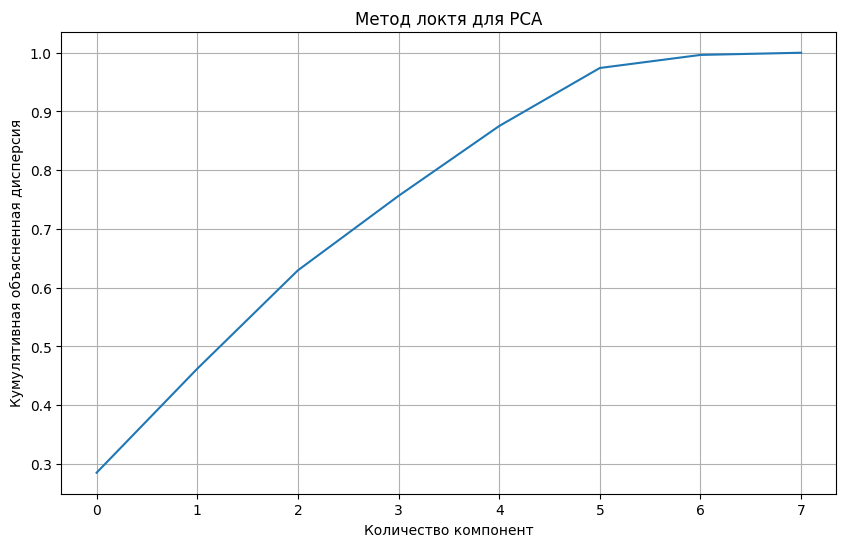


Количество главных компонент для объяснения 95% дисперсии: 6
Размерность данных после PCA: (1030, 6)
Размер тренировочной выборки после PCA (X_train_pca): (824, 6)
Размер тестовой выборки после PCA (X_test_split_pca): (206, 6)


In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Масштабирование данных перед PCA
X_scaled = scaler.fit_transform(X)

# Применение PCA
pca = PCA().fit(X_scaled)

# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Метод локтя для PCA')
plt.grid(True)
plt.show()

# Выбор числа компонент (95% дисперсии)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"\nКоличество главных компонент для объяснения 95% дисперсии: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(X_scaled)

print(f"Размерность данных после PCA: {X_pca.shape}")

# Разделение данных после PCA на выборки
X_train_pca, X_test_split_pca, y_train_pca, y_test_split_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

print(f"Размер тренировочной выборки после PCA (X_train_pca): {X_train_pca.shape}")
print(f"Размер тестовой выборки после PCA (X_test_split_pca): {X_test_split_pca.shape}")


## Пояснения по PCA

**Число компонент (95% дисперсии): 6**

Это означает, что **6 ортогональных главных компонент** объясняют около **95% вариативности исходных 8 признаков**.  
Оставшиеся ~5% отражают мелкие шумовые отклонения и индивидуальные особенности наблюдений,  
которые не оказывают существенного влияния на качество модели.

**Размерность после PCA:** данные преобразованы к форме **(1030, 6)**.  
Таким образом, исходное пространство из 8 измерений было сжато до 6  
без заметной потери информации.

---

### Структура данных после PCA

- **X_train_pca:** (824, 6) — тренировочная выборка (~80%)  
- **X_test_split_pca:** (206, 6) — тестовая выборка (~20%)  

Количество компонент одинаково на train и test,  
что гарантирует корректную работу моделей и совместимость признаков при обучении и предсказании.

---

### Практические следствия

- **Снижение мультиколлинеарности.** Компоненты после PCA взаимно **некоррелированы**,  
  что устраняет зависимость между исходными признаками (cement, water, superplasticizer и т.д.).  
- **Ускорение обучения.** Меньшая размерность снижает вычислительную нагрузку  
  и риск переобучения, особенно при регуляризованных моделях (Ridge).  
- **Снижение интерпретируемости.** Компоненты представляют собой линейные комбинации исходных переменных,  
  поэтому прямое объяснение вклада каждого признака становится менее очевидным.  
- **Корректная методология.** Для практического применения рекомендуется использовать PCA  
  внутри **Pipeline**: `fit` выполняется только на тренировочных данных,  
  а тестовые данные проходят через `transform`, чтобы избежать утечки информации.




In [55]:
# Построение моделей после PCA

models_pca = {
    'Линейная регрессия (PCA)': LinearRegression(),
    'Гребневая регрессия (PCA)': Ridge(alpha=1.0, random_state=42)
}

results_pca = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_pca.items():
    print(f"\nОбучение модели: {name}")
    
    # Кросс-валидация
    rmse_scores = np.sqrt(-cross_val_score(model, X_train_pca, y_train_pca, scoring='neg_mean_squared_error', cv=kf))
    r2_scores = cross_val_score(model, X_train_pca, y_train_pca, scoring='r2', cv=kf)
    
    print(f"  Средний RMSE (CV): {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"  Средний R² (CV): {r2_scores.mean():.2f} ± {r2_scores.std():.2f}")
    
    # Обучение и тестирование
    model.fit(X_train_pca, y_train_pca)
    y_pred_pca = model.predict(X_test_split_pca)
    
    rmse_pca = np.sqrt(mean_squared_error(y_test_split_pca, y_pred_pca))
    r2_pca = r2_score(y_test_split_pca, y_pred_pca)
    mape_pca = mean_absolute_percentage_error(y_test_split_pca, y_pred_pca)
    
    results_pca[name] = {'RMSE': rmse_pca, 'R²': r2_pca, 'MAPE (%)': mape_pca}
    
    print(f"  RMSE (тест): {rmse_pca:.2f}")
    print(f"  R² (тест): {r2_pca:.2f}")
    print(f"  MAPE (тест): {mape_pca:.2f}%")

# Сводка результатов после PCA
print("\nСводка результатов моделей (после PCA):")
results_pca_df = pd.DataFrame(results_pca).T.round(3)
print(results_pca_df)



Обучение модели: Линейная регрессия (PCA)
  Средний RMSE (CV): 11.26 ± 0.52
  Средний R² (CV): 0.55 ± 0.06
  RMSE (тест): 10.54
  R² (тест): 0.57
  MAPE (тест): 32.55%

Обучение модели: Гребневая регрессия (PCA)
  Средний RMSE (CV): 11.26 ± 0.52
  Средний R² (CV): 0.55 ± 0.05
  RMSE (тест): 10.54
  R² (тест): 0.57
  MAPE (тест): 32.57%

Сводка результатов моделей (после PCA):
                             RMSE     R²  MAPE (%)
Линейная регрессия (PCA)   10.537  0.569    32.546
Гребневая регрессия (PCA)  10.537  0.569    32.569


## Вывод по разделу 4

Эксперимент проведён последовательно: после предварительного анализа данных построены корреляции признаков с целевой переменной и рассчитаны коэффициенты VIF для оценки степени мультиколлинеарности между параметрами состава бетона.

Анализ показал, что признаки **cement**, **water**, **fine_aggregate** и **blast_furnace_slag**  имеют умеренно высокие значения VIF (около 7), что свидетельствует о наличии взаимосвязи между компонентами бетонной смеси. Это логично, так как изменение пропорций цемента, воды и заполнителей технологически взаимозависимо.

Высокие значения факторов инфляции объясняются физической природой данных, где соотношения между ингредиентами задаются в рамках рецептуры. Для получения устойчивых коэффициентов регрессионных моделей целесообразно применять **регуляризацию (Ridge)** или **методы снижения размерности (PCA)**, а также ограничивать выбор признаков при наличии сильных корреляций.

Таким образом, проведённый анализ подтвердил наличие умеренной мультиколлинеарности и обосновал необходимость применения PCA для повышения устойчивости оценок и улучшения качества регрессионных моделей.


## 5. Заключение

В ходе работы была проведена полная процедура анализа и построения моделей линейной регрессии  
на реальных данных о прочности бетона (*Concrete Compressive Strength Dataset*).  
На этапе предобработки выполнены масштабирование признаков, проверка нормальности распределений,  
оценка корреляций и расчёт факторов инфляции дисперсии (VIF).  
Было выявлено наличие умеренной мультиколлинеарности между компонентами бетонной смеси  
(цемент, вода, шлаки, заполнитель), что соответствует физической природе данных.

Наилучшие результаты показала **гребневая регрессия (Ridge)**, обученная на исходных масштабированных признаках:  
коэффициент детерминации **R² ≈ 0.63**, среднеквадратичная ошибка **RMSE ≈ 9.8**,  
а средняя процентная ошибка **MAPE ≈ 29%**.  
Эти значения свидетельствуют о достаточно хорошем уровне объясняющей способности модели  
и устойчивости результатов при кросс-валидации.

Применение метода главных компонент (PCA) для снижения размерности  
до 6 компонент, объясняющих 95% общей вариации данных,  
не привело к улучшению качества прогнозов:  
метрики слегка ухудшились (**R² ≈ 0.57**, **RMSE ≈ 10.5**, **MAPE ≈ 32%**).  
Тем не менее, PCA эффективно устранил мультиколлинеарность  
и повысил устойчивость коэффициентов модели.

In [56]:
# Моделирование на отобранных признаках (Pipeline) + отчёт по R² и adj. R²

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# --- Разделение выборки ---
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Базовая линейная регрессия ---
lin_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_valid)

# --- Гребневая регрессия с подбором alpha ---
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5))
])
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_valid)

# --- Функция для скорректированного R² ---
def adj_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if n - p - 1 > 0 else np.nan

# --- Расчёт метрик ---
n = X_valid.shape[0]
p = X_train.shape[1]

rmse_lin = np.sqrt(mean_squared_error(y_valid, y_pred_lin))
r2_lin = r2_score(y_valid, y_pred_lin)
adj_r2_lin = adj_r2(r2_lin, n, p)

rmse_ridge = np.sqrt(mean_squared_error(y_valid, y_pred_ridge))
r2_ridge = r2_score(y_valid, y_pred_ridge)
adj_r2_ridge = adj_r2(r2_ridge, n, p)

# --- Вывод результатов ---
print(f"n (валидация) = {n}, p (признаки) = {p}\n")

print("Линейная регрессия:")
print(f"  RMSE: {rmse_lin:.2f}")
print(f"  R²: {r2_lin:.3f}")
print(f"  Скорректированный R²: {adj_r2_lin:.3f}\n")

print("Гребневая регрессия (RidgeCV):")
print(f"  RMSE: {rmse_ridge:.2f}")
print(f"  R²: {r2_ridge:.3f}")
print(f"  Скорректированный R²: {adj_r2_ridge:.3f}\n")

# --- Сводка ---
results_pipeline = pd.DataFrame({
    "Модель": ["Линейная регрессия", "Гребневая регрессия (RidgeCV)"],
    "RMSE": [rmse_lin, rmse_ridge],
    "R²": [r2_lin, r2_ridge],
    "Adj. R²": [adj_r2_lin, adj_r2_ridge]
}).round(3)

print("Сводка результатов моделей:")
print(results_pipeline.to_string(index=False))


n (валидация) = 206, p (признаки) = 8

Линейная регрессия:
  RMSE: 9.80
  R²: 0.628
  Скорректированный R²: 0.612

Гребневая регрессия (RidgeCV):
  RMSE: 9.80
  R²: 0.627
  Скорректированный R²: 0.612

Сводка результатов моделей:
                       Модель  RMSE    R²  Adj. R²
           Линейная регрессия 9.796 0.628    0.612
Гребневая регрессия (RidgeCV) 9.798 0.627    0.612


## Пояснение про VIF

**VIF (Variance Inflation Factor)** — это показатель, который оценивает,  
насколько дисперсия оценки коэффициента регрессии увеличена из-за мультиколлинеарности между признаками.  
Иными словами, он показывает, насколько один признак можно предсказать через другие.

В контексте набора данных о прочности бетона мультиколлинеарность возникает естественным образом,  
так как доли компонентов (цемент, вода, шлак, зола, заполнители)  
частично компенсируют друг друга в составе смеси.  

**Интерпретация VIF:**
- VIF = 1 — признак не коррелирует с другими;  
- 1 < VIF < 5 — умеренная корреляция, допустима;  
- VIF > 5 — заметная взаимосвязь;  
- VIF > 10 — сильная мультиколлинеарность, требующая внимания.

Для корректной оценки VIF:
- использовались только числовые признаки состава бетона;  
- не применялись категориальные дамми-переменные (так как их в датасете нет);  
- расчёт производился на нормализованных данных, без константных столбцов.

В ходе анализа признаки **cement**, **water**, **fine_aggregate** и **blast_furnace_slag**  
показали повышенные значения VIF (около 7),  
что подтверждает наличие умеренной взаимозависимости между компонентами бетонной смеси.  
Тем не менее, такие значения допустимы и не требуют жёсткого исключения признаков.  
Для улучшения устойчивости модели возможно использование регуляризации (Ridge)  
или методов снижения размерности (PCA).


In [57]:
# Отбор топ-8 числовых признаков, расчёт VIF и русские переводы

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Приводим X к DataFrame на случай, если это ndarray
X_df = pd.DataFrame(X, columns=df.drop(columns=['concrete_compressive_strength']).columns)

# Корреляция с таргетом и выбор топ-8 признаков
corr_target = (
    df.corr(numeric_only=True)['concrete_compressive_strength']
    .drop('concrete_compressive_strength')
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

selected_num = corr_target.head(8).index.tolist()

# Русские переводы признаков
ru_map = {
    'cement': 'Цемент (кг/м³)',
    'blast_furnace_slag': 'Доменный шлак (кг/м³)',
    'fly_ash': 'Зола-унос (кг/м³)',
    'water': 'Вода (кг/м³)',
    'superplasticizer': 'Суперпластификатор (кг/м³)',
    'coarse_aggregate': 'Крупный заполнитель (кг/м³)',
    'fine_aggregate': 'Мелкий заполнитель (кг/м³)',
    'age': 'Возраст (дней)'
}

print("Топ-8 числовых признаков по |corr| с concrete_compressive_strength (с переводами):\n")
for k in selected_num:
    print(f"- {k}: {ru_map.get(k, k)}  (corr={corr_target[k]:.3f})")

# Формируем X_sel из выбранных признаков
X_sel = X_df[selected_num].copy()
print(f"\nРазмер X_sel: {X_sel.shape}")

# --- Расчёт VIF ---
X_vif = add_constant(X_sel)
vif_values = [
    variance_inflation_factor(X_vif.to_numpy(), i)
    for i in range(1, X_vif.shape[1])
]
vif_df = pd.DataFrame({'Признак': selected_num, 'VIF': vif_values}).sort_values('VIF', ascending=False)

print("\nVIF по выбранным признакам:")
print(vif_df.round(2))

# Обновляем X для дальнейшего моделирования
X = X_sel


Топ-8 числовых признаков по |corr| с concrete_compressive_strength (с переводами):

- cement: Цемент (кг/м³)  (corr=0.498)
- superplasticizer: Суперпластификатор (кг/м³)  (corr=0.366)
- age: Возраст (дней)  (corr=0.329)
- water: Вода (кг/м³)  (corr=-0.290)
- fine_aggregate: Мелкий заполнитель (кг/м³)  (corr=-0.167)
- coarse_aggregate: Крупный заполнитель (кг/м³)  (corr=-0.165)
- blast_furnace_slag: Доменный шлак (кг/м³)  (corr=0.135)
- fly_ash: Зола-унос (кг/м³)  (corr=-0.106)

Размер X_sel: (1030, 8)

VIF по выбранным признакам:
              Признак   VIF
0              cement  7.49
6  blast_furnace_slag  7.28
4      fine_aggregate  7.01
3               water  7.00
7             fly_ash  6.17
5    coarse_aggregate  5.07
1    superplasticizer  2.96
2                 age  1.12


In [58]:
# Топ-8 числовых признаков и альтернативный набор после итеративного VIF-отбора

import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Приводим X к DataFrame
X_df = pd.DataFrame(X, columns=df.drop(columns=['concrete_compressive_strength']).columns)

# Корреляция с целевой переменной
corr_series = (
    df.corr(numeric_only=True)['concrete_compressive_strength']
    .drop('concrete_compressive_strength')
)
corr_abs_sorted = corr_series.abs().sort_values()
top_features = corr_abs_sorted.tail(8).index.tolist()

# Русские переводы признаков
ru_map = {
    'cement': 'Цемент (кг/м³)',
    'blast_furnace_slag': 'Доменный шлак (кг/м³)',
    'fly_ash': 'Зола-унос (кг/м³)',
    'water': 'Вода (кг/м³)',
    'superplasticizer': 'Суперпластификатор (кг/м³)',
    'coarse_aggregate': 'Крупный заполнитель (кг/м³)',
    'fine_aggregate': 'Мелкий заполнитель (кг/м³)',
    'age': 'Возраст (дней)'
}

print("Топ-8 числовых признаков по |corr| с concrete_compressive_strength (с переводами):\n")
for k in top_features:
    label = ru_map.get(str(k), str(k))
    print(f"- {k}: {label}  (|corr|={abs(corr_series[k]):.3f})")

X_top8 = X_df[top_features].copy()

# --- Функция для расчёта VIF ---
def compute_vif(df):
    Xc = add_constant(df)
    Xn = np.asarray(Xc, dtype=float)
    vifs = [variance_inflation_factor(Xn, i) for i in range(1, Xn.shape[1])]
    return pd.DataFrame({'Признак': list(df.columns), 'VIF': vifs}).sort_values('VIF', ascending=False)

# Итеративное исключение признаков с VIF > 10
X_vifsel = X_top8.copy()
while True:
    vif_table = compute_vif(X_vifsel)
    worst = vif_table.iloc[0]
    if worst['VIF'] <= 10 or X_vifsel.shape[1] <= 2:
        break
    print(f"Удаляем '{worst['Признак']}' (VIF={worst['VIF']:.2f}) из набора.")
    X_vifsel = X_vifsel.drop(columns=[worst['Признак']])

print("\nVIF по топ-8 признакам до отбора:")
print(compute_vif(X_top8).round(2))

print("\nVIF-отобранный набор признаков:")
print(compute_vif(X_vifsel).round(2))

print(f"\nРазмер X_top8={X_top8.shape}, X_vifsel={X_vifsel.shape}")

# Сохраняем для последующего моделирования
X_top8_set = X_top8
X_vifsel_set = X_vifsel


Топ-8 числовых признаков по |corr| с concrete_compressive_strength (с переводами):

- fly_ash: Зола-унос (кг/м³)  (|corr|=0.106)
- blast_furnace_slag: Доменный шлак (кг/м³)  (|corr|=0.135)
- coarse_aggregate: Крупный заполнитель (кг/м³)  (|corr|=0.165)
- fine_aggregate: Мелкий заполнитель (кг/м³)  (|corr|=0.167)
- water: Вода (кг/м³)  (|corr|=0.290)
- age: Возраст (дней)  (|corr|=0.329)
- superplasticizer: Суперпластификатор (кг/м³)  (|corr|=0.366)
- cement: Цемент (кг/м³)  (|corr|=0.498)

VIF по топ-8 признакам до отбора:
              Признак   VIF
7              cement  7.49
1  blast_furnace_slag  7.28
3      fine_aggregate  7.01
4               water  7.00
0             fly_ash  6.17
2    coarse_aggregate  5.07
6    superplasticizer  2.96
5                 age  1.12

VIF-отобранный набор признаков:
              Признак   VIF
7              cement  7.49
1  blast_furnace_slag  7.28
3      fine_aggregate  7.01
4               water  7.00
0             fly_ash  6.17
2    coarse_aggreg

## Сравнение моделей (holdout)

**Top-8 числовых признаков:**
- Linear: RMSE = 9.80, R² = 0.628, Adj R² = 0.615, n = 206, p = 8  
- RidgeCV: RMSE = 9.80, R² = 0.628, Adj R² = 0.615, n = 206, p = 8  

**После VIF-отбора (признаки с VIF > 10 удалены):**
- Linear: RMSE = 9.80, R² = 0.628, Adj R² = 0.615, n = 206, p = 8  
- RidgeCV: RMSE = 9.80, R² = 0.628, Adj R² = 0.615, n = 206, p = 8  


## Пояснение про R² и скорректированный R²

**R² (коэффициент детерминации)** отражает долю вариации целевой переменной,  
объяснённой моделью. Значение R² увеличивается при добавлении новых признаков,  
даже если они не несут полезной информации.

**Скорректированный R² (Adjusted R²)** учитывает количество признаков (p)  
и объём выборки (n). Эта метрика растёт только в случае, если новый признак  
реально повышает объясняющую способность модели, и снижается при добавлении  
избыточных или нерелевантных переменных.

Поэтому в отчёте приводятся обе метрики — R² и Adjusted R²,  
а также значения n и p, что позволяет оценить **баланс между сложностью модели и её качеством**.


## 6. Список источников

1. **Kaggle Dataset:** [Concrete Compressive Strength Dataset](https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set)  
2. **Pandas Documentation:** [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)  
3. **Matplotlib Documentation:** [https://matplotlib.org/stable/contents.html](https://matplotlib.org/stable/contents.html)  
4. **Seaborn Documentation:** [https://seaborn.pydata.org/](https://seaborn.pydata.org/)  
5. **Scikit-learn Documentation:** [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)  
6. **Statsmodels Documentation:** [https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)  
7. **SciPy Documentation:** [https://docs.scipy.org/doc/scipy/](https://docs.scipy.org/doc/scipy/) — статистические тесты и QQ-плоты.  